<span style='background-color: #F7DDBE'>**D&A EDA COMPETITION**</span> - 에바행조 소스코드
===========================================

**<목차>**
--------------
### **1.** 모듈 불러오기 및 CSV 파일 로드
### **2.** 데이터 전처리

* 데이터프레임 편집
<br/><br/>
* age_group
<br/><br/>
* price
<br/><br/>
* buy_count
<br/><br/>
* buy_date

### **3.** 데이터 분석 및 시각화
* 고객 분석 및 시각화
<br/><br/>
* 수량 분석 및 시각화 
<br/><br/>
* 가격 분석 및 시각화
<br/><br/>
* 시기 분석 및 시각화
<br/><br/>
* 시간 분석 및 시각화
<br/><br/>
* 지역 분석 및 시각화

### **4.** 여름 신제품 출시 활용(가격)

## **1. 모듈 불러오기 및 CSV 파일 로드**

In [1]:
#각종 모듈 불러오기
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter('ignore')

# 한글 폰트 설정 
from matplotlib import font_manager, rc
import platform

your_os = platform.system()
if your_os == 'Linux':
    rc('font', family = 'NanumGothic')
elif your_os == 'Windows':
    ttf = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=ttf).get_name()
    rc('font', family = font_name)
elif your_os == 'Darwin':
    rc('font', family = 'AppleGothic')
rc('axes', unicode_minus = False)

In [2]:
sns.set_theme(style='whitegrid', font_scale=1.5)
sns.set_palette('Set2', n_colors=10)
plt.rc('font', family='malgun gothic')
plt.rc('axes', unicode_minus=False)

In [3]:
c = pd.read_csv('EDA_Competition_Data/customer_data.csv') #고객정보 데이터 불러오기
o = pd.read_csv('EDA_Competition_Data/order_data.csv')    #주문정보 데이터 불러오기
p = pd.read_csv('EDA_Competition_Data/product_data.csv')  #상품정보 데이터 불러오기

## **2. 데이터 전처리**

### 1) 분석에 필요한 데이터프레임 편집
- c, o, p merge
- 온라인 매장 삭제
- 필요하지 않은 칼럼 삭제
- 주류 데이터만 추출

In [4]:
# c(고객데이터), o(주문데이터), p(상품데이터) 병합
co = pd.merge(c, o, on='customer_id')
df = pd.merge(co, p, on='product_code')

In [5]:
# 오프라인 매장만 (온라인 매장 삭제)
df = df.drop(df[df['on_off_div']==2].index)

In [6]:
# 필요하지 않은 컬럼 삭제(영수증, 온/오프라인, 유통사코드, 상품코드)
col = ['order_id','on_off_div','partner_code','product_code']
df = df.drop(col, axis=1)

In [7]:
# 주류 데이터만 추출(주류 상품만 나타내기)
df = df.loc[df['large_product_cat']=='주류']

In [8]:
# 인덱스를 삭제하고 재설정
df = df.reset_index(drop=True)

In [9]:
df.head()

,customer_id,gender,age_group,location,market_code,buy_date,buy_hour,buy_amount,buy_count,product,large_product_cat,mid_product_cat
0,M000034966,여성,40대,Z07,A020116,20210919,16,16440.0,2,국산맥주,주류,맥주
1,M000034966,여성,40대,Z07,A043676,20210116,21,10800.0,4,국산맥주,주류,맥주
2,M000136117,여성,30대,Z11,A020092,20210104,17,8220.0,1,국산맥주,주류,맥주
3,M000201112,여성,50대,Z17,A043753,20210725,15,8000.0,4,국산맥주,주류,맥주
4,M000504230,여성,30대,Z05,A030304,20210219,17,9240.0,1,국산맥주,주류,맥주


### 2) age_group
- 60대 + 70대 -> 60대 이상으로 처리

In [10]:
# 연령대 고객 수
df['age_group'].value_counts() 

40대    68753
30대    43586
50대    35025
20대    11248
60대     8600
70대     2415
Name: age_group, dtype: int64

In [11]:
# 60대 + 70대 -> 70대 이상
my_dict = {'60대': '60대 이상','70대': '60대 이상'}
df['age_group'] = df['age_group'].replace(my_dict)

In [12]:
df['age_group'].value_counts()

40대       68753
30대       43586
50대       35025
20대       11248
60대 이상    11015
Name: age_group, dtype: int64

### 3) price
- price(상품 하나당 가격) 칼럼 추가
- 중분류별로 극단치 처리

In [13]:
# 상품 하나당 가격(price) 컬럼 추가
price=df['buy_amount']/df['buy_count']
df.insert(8,'price',price)

In [14]:
# 주류 중분류별로 따로 떼내기
beer=df[df['mid_product_cat']=='맥주']
soju=df[df['mid_product_cat']=='소주']
trad=df[df['mid_product_cat']=='전통주']
wine=df[df['mid_product_cat']=='와인']
oset=df[df['mid_product_cat']=='주류세트']
fore=df[df['mid_product_cat']=='양주']

In [15]:
beer['mid_product_cat'].value_counts()

맥주    87669
Name: mid_product_cat, dtype: int64

In [16]:
# 극단치 처리 함수

def deal_with_extremes(kind):
    
    # 상위 10% -> 상위 10% 속하는 값들의 중앙값
    q9=kind['price'].quantile(q=0.9, interpolation='nearest')
    m9=kind.loc[kind['price']>=q9]['price'].median()
    kind['price'].loc[kind['price']>=q9]=m9
    
    # 하위 10% -> 하위 10% 속하는 값들의 중앙값
    q1=kind['price'].quantile(q=0.1, interpolation='nearest')
    m1=kind.loc[kind['price']<=q1]['price'].median()
    kind['price'].loc[kind['price']<=q1]=m1

In [17]:
deal_with_extremes(beer)
deal_with_extremes(soju)
deal_with_extremes(trad)
deal_with_extremes(wine)
deal_with_extremes(oset)
deal_with_extremes(fore)

### 4) buy_count
- 7개 이상의 값을 '7개 이상'으로 처리

In [18]:
df['buy_count'].value_counts()

1     108550
2      35042
4       9893
3       8838
6       2408
5       2407
8        819
10       390
12       315
7        309
20       139
9         93
24        81
15        61
18        45
11        37
13        30
14        28
25        24
16        22
21        16
30        15
32         9
19         9
48         8
17         7
23         5
22         4
27         4
40         3
72         2
60         2
26         2
28         1
63         1
34         1
33         1
37         1
36         1
96         1
29         1
31         1
35         1
Name: buy_count, dtype: int64

In [19]:
# 7개 이상은 7로 표기하지만 의미는 7개 이상 !!
df['buy_count'] = df['buy_count'].clip(upper=7)

In [20]:
df['buy_count'].value_counts()

1    108550
2     35042
4      9893
3      8838
7      2489
6      2408
5      2407
Name: buy_count, dtype: int64

### 5) buy_date
- 년 추출하여 year 컬럼 추가
- 월 추출하여 month 컬럼 추가
- 일 추출하여 day 컬럼 추가

In [21]:
# datetime 모듈로 buy_date 형식 변환
df['buy_date'] = pd.to_datetime(df['buy_date'].astype(str), format='%Y-%m-%d')

# 년 추출 -> year 컬럼 추가
year = df['buy_date'].dt.year
df.insert(5,'year',year)

# 월 추출 -> month 컬럼 추가
month = df['buy_date'].dt.month
df.insert(5,'month',month)

# 일 추출 -> day 컬럼
day = df['buy_date'].dt.day
df.insert(5,'day',day)

In [22]:
# 일/월/년 컬럼
df.loc[:,df.columns[5:8]].head()

,day,month,year
0,19,9,2021
1,16,1,2021
2,4,1,2021
3,25,7,2021
4,19,2,2021


In [23]:
# 모든 주류 중분류에 전처리 과정 적용
beer=df[df['mid_product_cat']=='맥주']
soju=df[df['mid_product_cat']=='소주']
trad=df[df['mid_product_cat']=='전통주']
wine=df[df['mid_product_cat']=='와인']
oset=df[df['mid_product_cat']=='주류세트']
fore=df[df['mid_product_cat']=='양주']

## **3. 데이터 분석 및 시각화**

### 1) <u>고객</u> 분석

In [24]:
# 주류를 산 여성/남성 고객 수
df['gender'].value_counts()

여성    107747
남성     61880
Name: gender, dtype: int64

In [25]:
# 주류를 구매한 연령별 고객 수
df['age_group'].value_counts()

40대       68753
30대       43586
50대       35025
20대       11248
60대 이상    11015
Name: age_group, dtype: int64

In [26]:
# 맥주를 산 연령대별 고객 수
beer['age_group'].value_counts()

40대       37182
30대       23632
50대       17386
20대        5828
60대 이상     3641
Name: age_group, dtype: int64

In [27]:
# 여성의 주류별 구매 고객 수 
df.query('gender == "여성"')['product'].value_counts()

국산맥주       30582
수입맥주       23628
일반소주       23323
막걸리         9317
레드와인        8244
화이트와인       2188
무알콜맥주       1565
청주          1473
칵테일소주       1468
과실주/담금주     1160
리큐르          857
기타전통주        790
와인세트         737
스파클링와인       669
위스키          621
중국술          308
기타양주         287
일본술          275
담금소주         140
양주세트          70
전통주세트         33
브랜디/꼬냑        12
Name: product, dtype: int64

### 1-1) <u>고객</u> 분석 시각화

Text(0.5, 1.0, '주류 구매 고객 수')

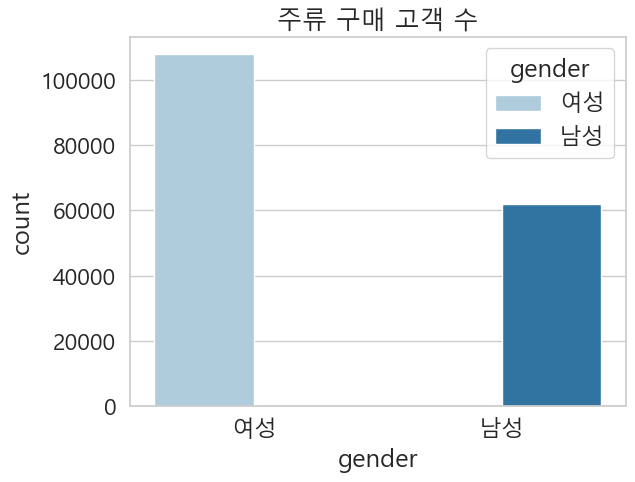

In [28]:
# 성별 주류 구매한 고객 수 비교
sns.countplot(x='gender', data=df, hue='gender', palette='Paired')
plt.title('주류 구매 고객 수')

Text(0.5, 1.0, '주류 구매 고객 수')

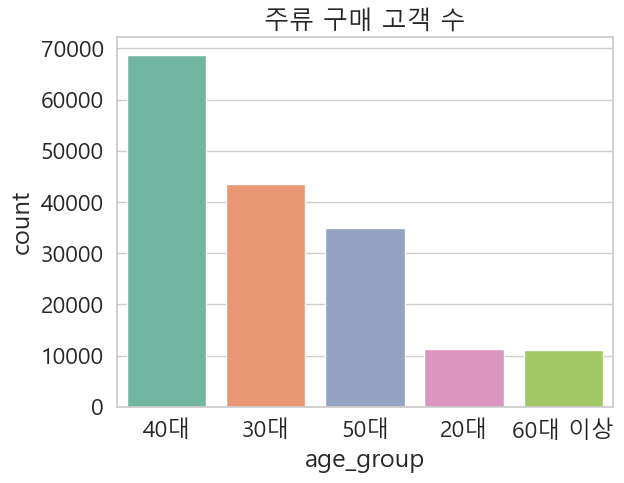

In [29]:
# 주류를 구매한 연령별 고객 수 비교
sns.countplot(x='age_group', data=df,  palette='Set2')
plt.title('주류 구매 고객 수')

Text(0.5, 1.0, '맥주 구매 고객 수')

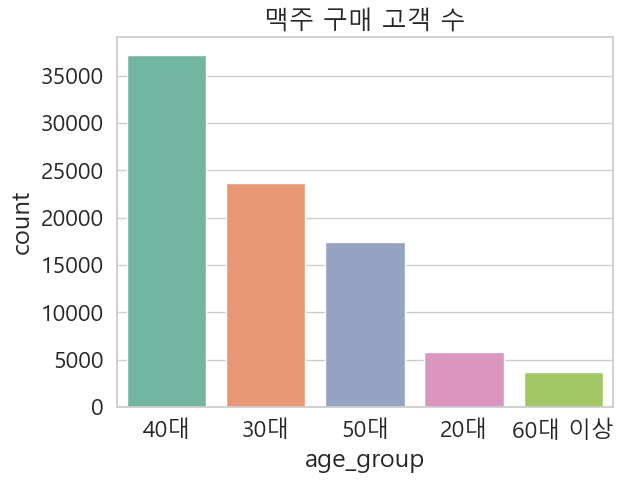

In [30]:
# 맥주를 구매한 연령별 고객 수 비교
beer  # 맥주를 구매한 고객 데이터

sns.countplot(x='age_group', data=beer,  palette='Set2')
plt.title('맥주 구매 고객 수')

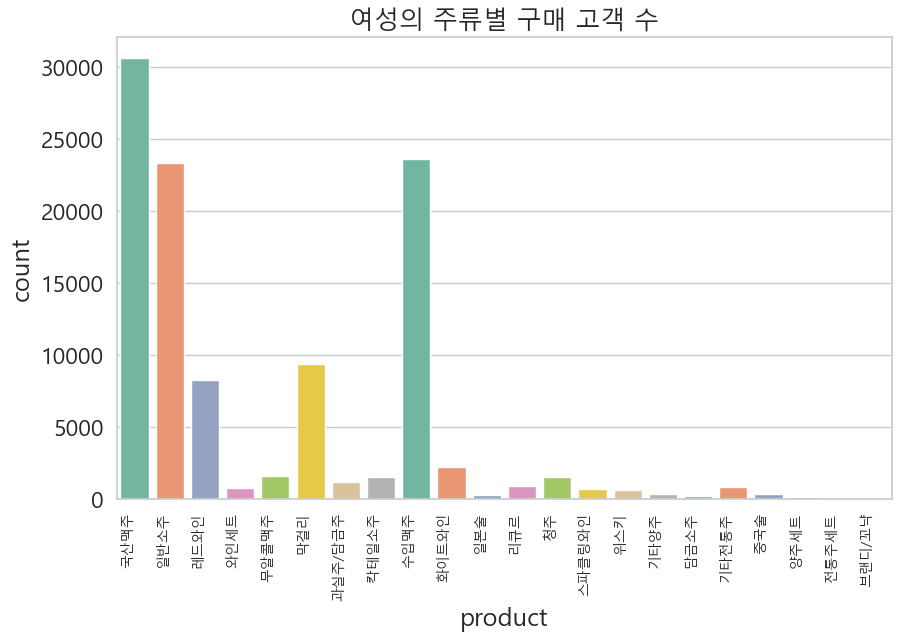

In [31]:
# 여성의 주류별 구매 고객 수
woman_df = df.query('gender == "여성"')  # 주류를 구매한 여성고객 데이터

plt.figure(figsize=(10, 6))  # 그래프 가로크기 10, 세로크기 6으로 설정
sns.countplot(x='product', data=woman_df, palette='Set2')
plt.xticks(rotation=90, ha='right', fontsize=10)  # x축 눈금을 90도 회전하고, 오른쪽 정렬하며, 크기를 10으로 설정
plt.title('여성의 주류별 구매 고객 수')
plt.show()

### 2) <u>수량</u> 분석

In [32]:
# 주류 중분류별 총 구매량
count_df = df.groupby(['mid_product_cat']).agg({'buy_count':'sum'});count_df

,buy_count
mid_product_cat,
맥주,160318
소주,69060
양주,4086
와인,21764
전통주,31565
주류세트,1833


In [33]:
# 맥주 구매 개수별 고객 수 (1개를 구매한 고객 수, 2개를 구매한 고객 수 ...)
beer['buy_count'].value_counts()

1    53587
2    17703
4     7527
3     4026
6     1687
7     1661
5     1478
Name: buy_count, dtype: int64

In [34]:
# 소주 구매 개수별 고객 수
soju['buy_count'].value_counts()

1    23016
2    10271
3     3142
4     1598
5      611
7      521
6      497
Name: buy_count, dtype: int64

In [35]:
# 전통주 구매 개수별 고객 수
trad['buy_count'].value_counts()

1    13580
2     4968
3     1203
4      486
5      207
6      121
7      105
Name: buy_count, dtype: int64

In [36]:
# 와인 구매 개수별 고객 수
wine['buy_count'].value_counts()

1    14788
2     1602
3      357
4      194
7      142
5       89
6       81
Name: buy_count, dtype: int64

In [37]:
# 주류세트 구매 개수별 고객 수
oset['buy_count'].value_counts()

1    1140
2     153
3      28
7      20
4      19
6      12
5       3
Name: buy_count, dtype: int64

In [38]:
# 양주 구매 개수별 고객 수
fore['buy_count'].value_counts()

1    2439
2     345
3      82
4      69
7      40
5      19
6      10
Name: buy_count, dtype: int64

### 2-1) <u>수량</u> 분석 시각화

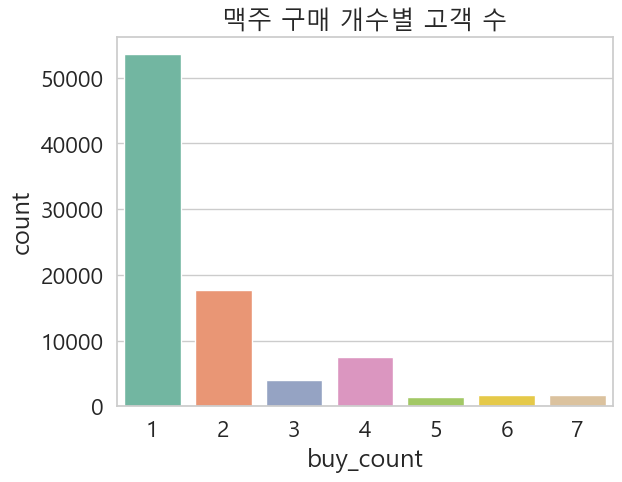

In [39]:
# 맥주 구매 개수별 고객 수 그래프
sns.countplot(x='buy_count',data=beer)
plt.title("맥주 구매 개수별 고객 수")
plt.show()

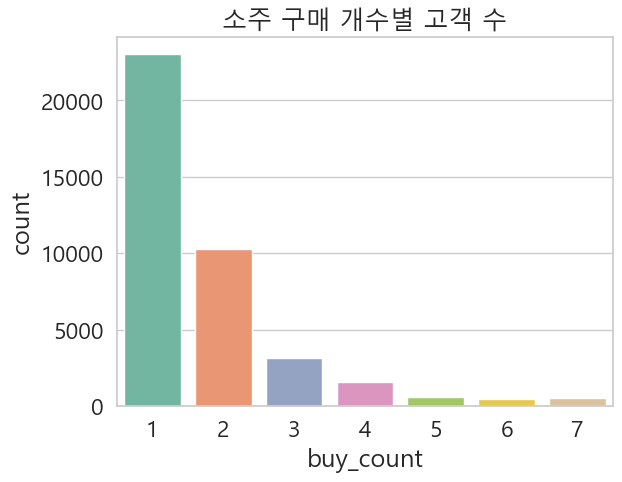

In [40]:
# 소주 구매 개수별 고객 수 그래프
sns.countplot(x='buy_count',data=soju)
plt.title("소주 구매 개수별 고객 수")
plt.show()

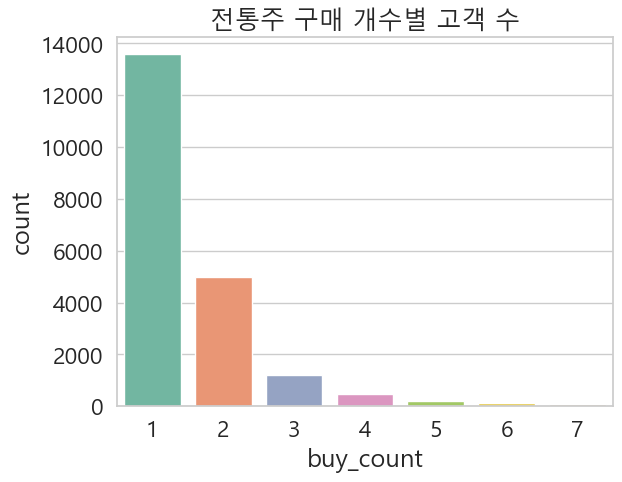

In [41]:
# 전통주 구매 개수별 고객 수 그래프
sns.countplot(x='buy_count',data=trad)
plt.title("전통주 구매 개수별 고객 수")
plt.show()

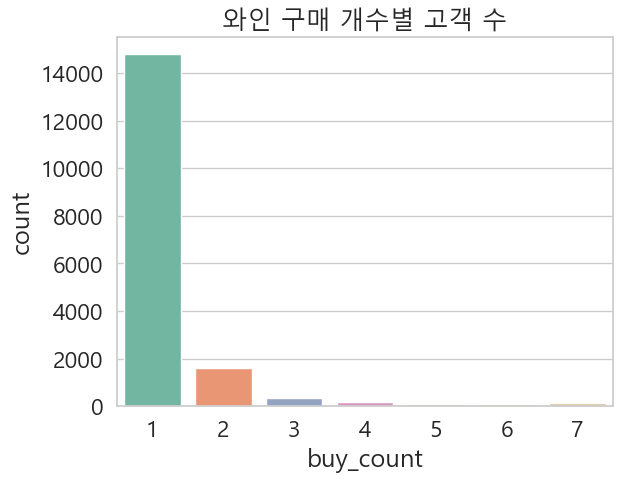

In [42]:
# 와인 구매 개수별 고객 수 그래프
sns.countplot(x='buy_count',data=wine)
plt.title("와인 구매 개수별 고객 수")
plt.show()

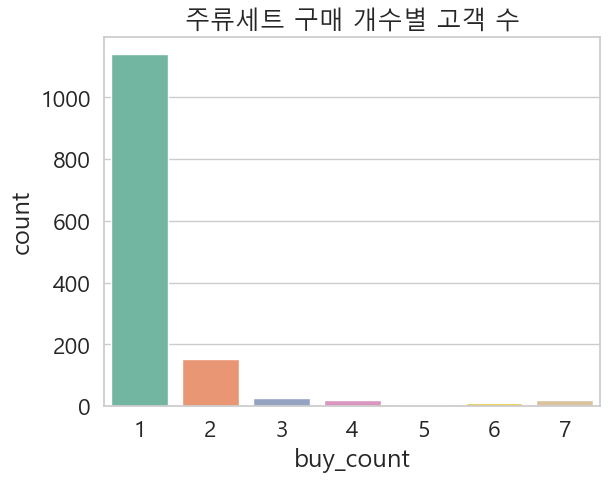

In [43]:
# 주류세트 구매 개수별 고객 수 그래프
sns.countplot(x='buy_count',data=oset)
plt.title("주류세트 구매 개수별 고객 수")
plt.show()

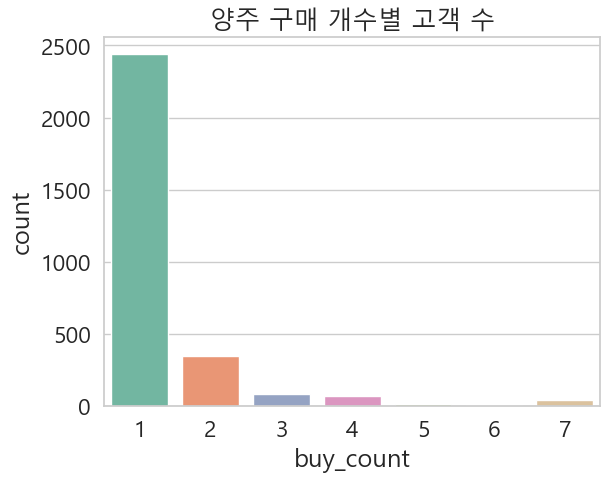

In [44]:
# 양주 구매 개수별 고객 수 그래프
sns.countplot(x='buy_count',data=fore)
plt.title("양주 구매 개수별 고객 수")
plt.show()

### 3) <u>가격</u> 분석

In [45]:
# 주류 중분류별(맥주, 소주, 전통주, ...) 평균가격/매출/판매량 데이터프레임 생성
money_df=df.groupby(['mid_product_cat']).agg({'price':'mean','buy_amount':'sum','buy_count':'sum'})
money_df=money_df.rename(columns={'price':'평균가격','buy_amount':'매출','buy_count':'판매량'})
money_df.sort_values('매출', ascending=False)

,평균가격,매출,판매량
mid_product_cat,,,
맥주,4324.559548,571956162.0,160318
와인,21422.899396,454916159.0,21764
소주,3136.505076,174067040.0,69060
양주,25829.061806,91639540.0,4086
전통주,2983.926755,83096560.0,31565
주류세트,37177.673675,66907020.0,1833


### 3-1) <u>가격</u> 분석 시각화

Text(0.5, 1.0, '주류 중분류별 평균 가격')

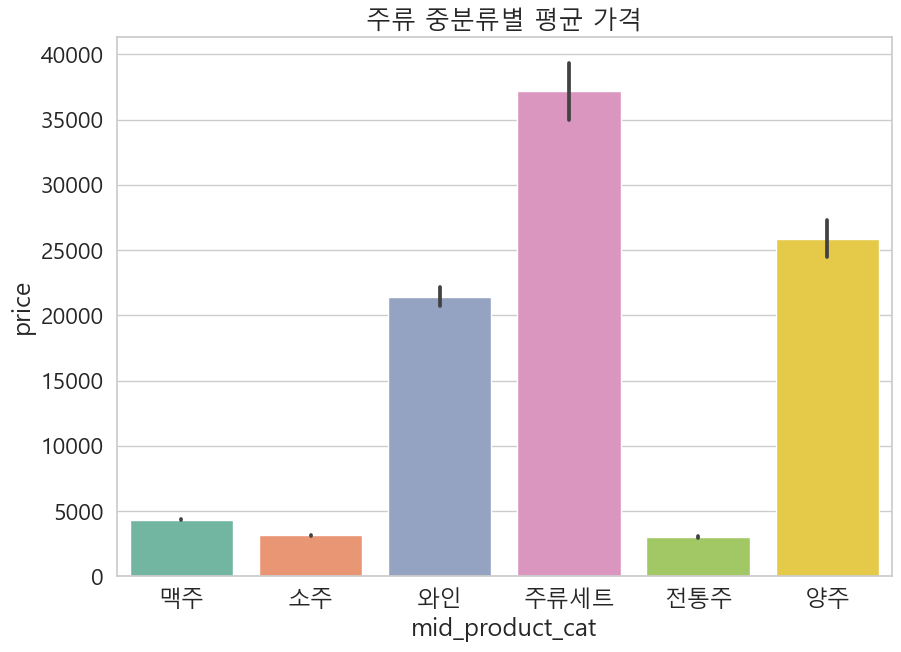

In [46]:
# 주류 중분류별 평균가격 그래프
plt.figure(figsize=(10,7))
sns.barplot(x='mid_product_cat', y='price', data=df)
plt.title('주류 중분류별 평균 가격')

- 가격대가 낮으면 더 많이 팔린다?
- 가격과 판매량의 관계 파악

Text(0.5, 1.0, '가격과 판매량의 관계')

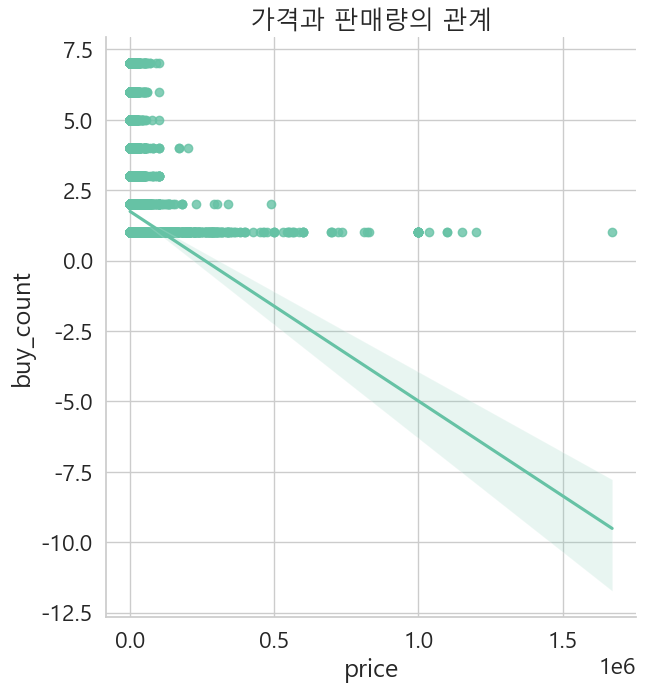

In [47]:
# 가격과 판매량의 관계 그래프
sns.lmplot(x='price', y='buy_count', height=7, data=df)
plt.title('가격과 판매량의 관계')

Text(0.5, 1.0, '주류 중분류별 가격과 판매량의 관계')

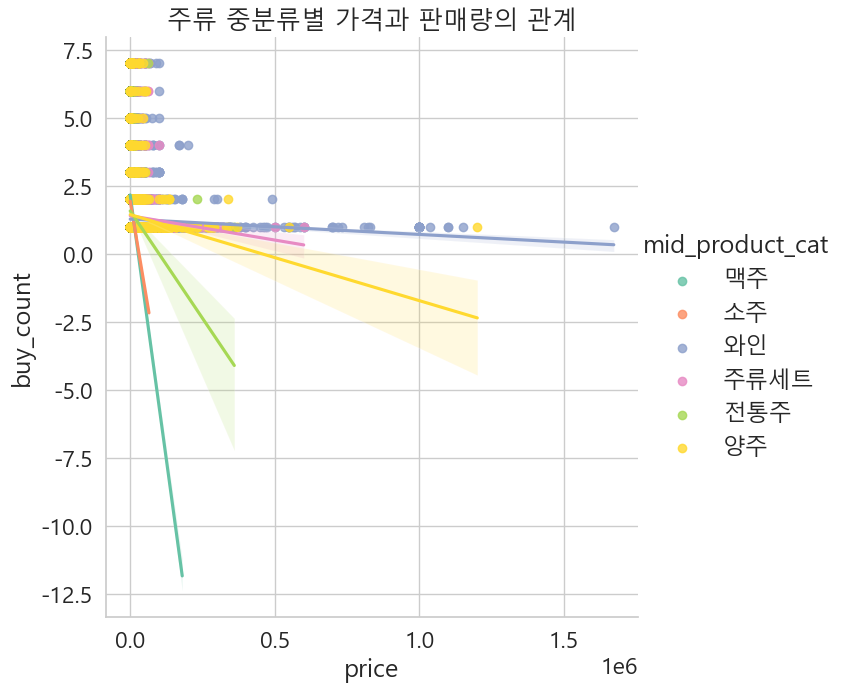

In [48]:
# 주류 중분류별 가격과 판매량의 관계 그래프
sns.lmplot(x='price', y='buy_count', hue='mid_product_cat', height=7, data=df)
plt.title('주류 중분류별 가격과 판매량의 관계')

Text(0.5, 1.0, '매출 top3 가격과 판매량의 관계')

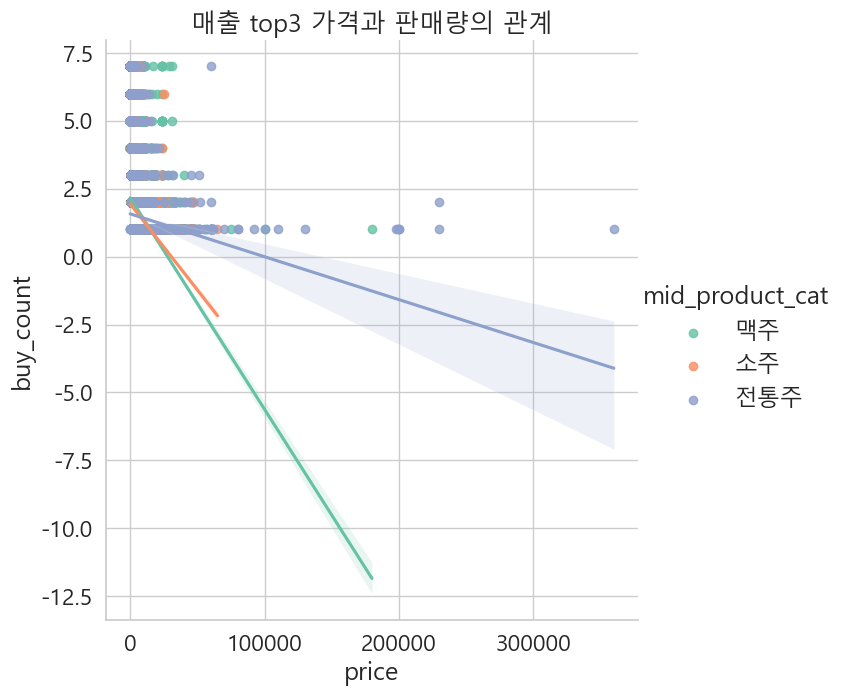

In [49]:
# 매출 상위 3가지 주류와 하위 3가지 주류 변수 생성
t3=pd.concat([beer,soju,trad])
b3=pd.concat([wine,oset,fore])

# 매출 상위 3가지 주류의 가격과 판매량의 관계 그래프
sns.lmplot(x='price', y='buy_count', hue='mid_product_cat', height=7, data=t3)
plt.title('매출 top3 가격과 판매량의 관계')

Text(0.5, 1.0, '매출 bottom3 가격과 판매량의 관계')

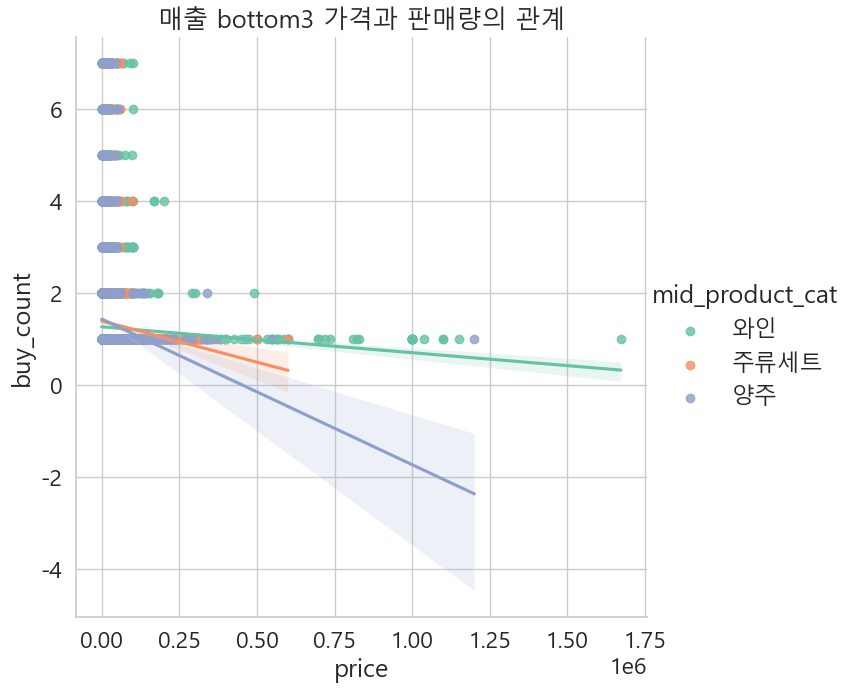

In [50]:
# 매출 하위 3가지 주류의 가격과 판매량의 관계 그래프
sns.lmplot(x='price', y='buy_count', hue='mid_product_cat', height=7, data=b3)
plt.title('매출 bottom3 가격과 판매량의 관계')

### 4) <u>시기</u>(일년, 월별 주류 판매량 추세) 분석

In [51]:
# 월별 주류 총 판매량
df.groupby(['month'])['buy_count'].sum()

month
1     25291
2     22363
3     21782
4     21875
5     25762
6     23048
7     28843
8     27679
9     24329
10    22964
11    19271
12    25419
Name: buy_count, dtype: int64

In [52]:
# 중분류별 주류의 판매량
df.groupby(['mid_product_cat']).sum()['buy_count'].reset_index()

,mid_product_cat,buy_count
0,맥주,160318
1,소주,69060
2,양주,4086
3,와인,21764
4,전통주,31565
5,주류세트,1833


In [53]:
# 월별 주류의 판매량 정규화

# 월별 주류의 판매량
buy_count_alc = df.groupby(['month'])['buy_count'].sum()

# 월별 주류의 판매량 정규화
(buy_count_alc - buy_count_alc.mean()) / buy_count_alc.std()

month
1     0.458490
2    -0.625157
3    -0.840184
4    -0.805765
5     0.632806
6    -0.371640
7     1.773077
8     1.342283
9     0.102455
10   -0.402728
11   -1.769500
12    0.505862
Name: buy_count, dtype: float64

In [54]:
# 월별 맥주의 판매량 정규화

# 월별 맥주의 판매량
buy_count_beer = beer.groupby(['month'])['buy_count'].sum()

# 월별 맥주 판매량 정규화
(buy_count_beer - buy_count_beer.mean()) / buy_count_beer.std()

month
1    -0.067839
2    -0.817981
3    -0.838957
4    -0.767039
5     0.562440
6     0.035043
7     2.057230
8     1.555804
9     0.192863
10   -0.191697
11   -1.365355
12   -0.354511
Name: buy_count, dtype: float64

### 4-1) <u>시기</u>(일년, 월별 주류 판매량 추세) 분석 시각화

In [55]:
# 주류의 월별 판매량 함수
def show_large_product_month(product):                          # 월별 대분류 주류 판매량 함수
    ex_df = df.query(f'large_product_cat == "{product}"')      
    monthly_count = ex_df.groupby(['month'])['buy_count'].sum() # '월'별로 groupby하고 'buy_count'열을 더한 것을 return
    
    return monthly_count

# 중분류 주류의 월별 판매량 함수
def show_mid_product_month(product):                         
    ex_df = df.query(f'mid_product_cat == "{product}"')      
    monthly_count = ex_df.groupby(['month'])['buy_count'].sum()

    return monthly_count


# 주류의 월별 판매량 추세 그래프 함수
def show_large_product_month_graph(product):
    plt.plot(list(range(1, 12+1)),(show_large_product_month(f'{product}')), c = 'black', marker = '.',linewidth=2, label = f'{product}')
    plt.legend()
    plt.title(f'2021년 월별 {product} 판매량')
    plt.xticks(list(range(1, 12+1)))
    plt.grid(True)
    plt.ylim((0,show_large_product_month(f'{product}').reset_index()['buy_count'].max() + show_large_product_month(f'{product}').reset_index()['buy_count'].max() / 5))  # y값 하한/상한선
    plt.axhline(show_large_product_month(f'{product}').reset_index()['buy_count'].mean(), color = 'r', linestyle = '--',)  # 평균선
    plt.text(0.5, (show_large_product_month(f'{product}').reset_index()['buy_count'].mean() * 1.15), (int(show_large_product_month(f'{product}').reset_index()['buy_count'].mean())), va='top', ha='left', color = 'r')  # 평균값 나타내기
    plt.show()

# 중분류 주류의 월별 판매량 추세 그래프 함수
def show_mid_product_month_graph(product):
    plt.plot(list(range(1, 12+1)),(show_mid_product_month(f'{product}')), c = 'black', marker = '.', label = f'{product}')
    plt.legend()
    plt.title(f'2021년 월별 {product} 판매량')
    plt.xticks(list(range(1, 12+1)))
    plt.grid(True)
    plt.ylim((0,show_mid_product_month(f'{product}').reset_index()['buy_count'].max() + show_mid_product_month(f'{product}').reset_index()['buy_count'].max() / 5))  # y값 하한/상한선
    plt.axhline(show_mid_product_month(f'{product}').reset_index()['buy_count'].mean(), color = 'r', linestyle = '--',)   # 평균선
    plt.text(0.5, (show_mid_product_month(f'{product}').reset_index()['buy_count'].mean() * 1.15), (int(show_mid_product_month(f'{product}').reset_index()['buy_count'].mean())), va='top', ha='left', color = 'r')  # 평균값 나타내기
    plt.show()


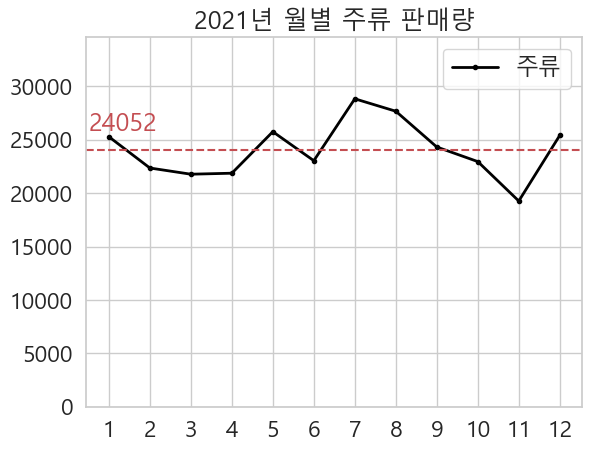

In [56]:
# 2021년 월별 주류 판매량 그래프와 평균선
show_large_product_month_graph("주류") 

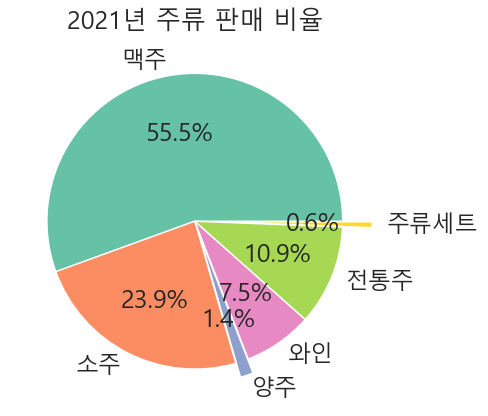

In [57]:
# 2021년 주류 판매 비율 파이차트
buy_count_mid = df.groupby(['mid_product_cat']).sum()['buy_count'].reset_index()

plt.pie(buy_count_mid['buy_count'].tolist(), labels=buy_count_mid['mid_product_cat'].tolist(), explode = [0, 0, 0.1, 0, 0, 0.2], autopct='%1.1f%%')
plt.title('2021년 주류 판매 비율')
plt.show()

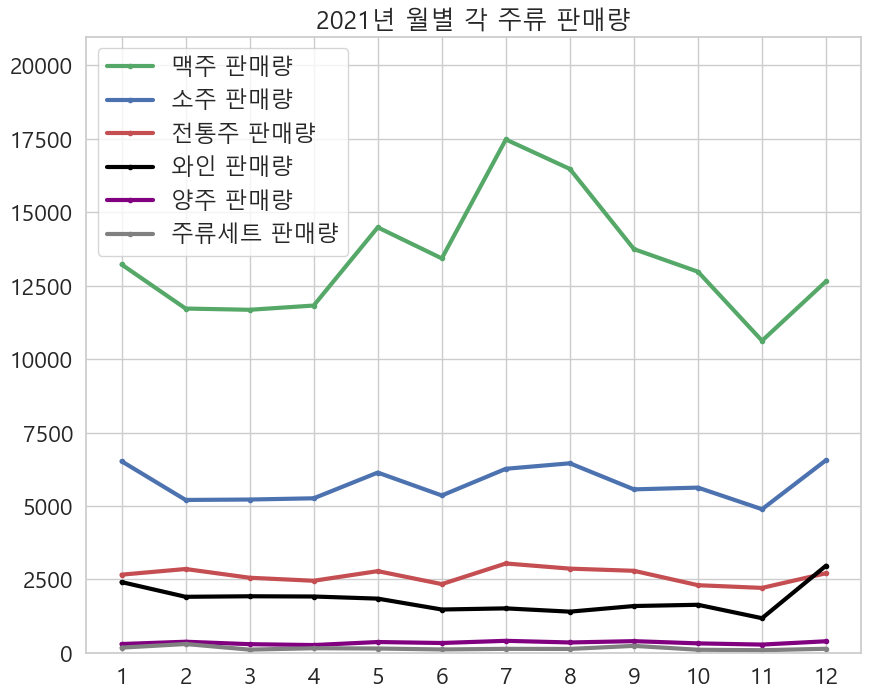

In [58]:
# 2021년 중분류별 주류 판매량 그래프
plt.figure(figsize= (10, 8))
plt.plot(list(range(1, 12+1)),(show_mid_product_month("맥주")), c = 'g', marker = '.', linewidth=3, label = '맥주 판매량')
plt.plot(list(range(1, 12+1)),(show_mid_product_month("소주")), c = 'b', marker = '.', linewidth=3, label = '소주 판매량')
plt.plot(list(range(1, 12+1)),(show_mid_product_month("전통주")), c = 'r', marker = '.', linewidth=3, label = '전통주 판매량')
plt.plot(list(range(1, 12+1)),(show_mid_product_month("와인")), c = 'black', marker = '.', linewidth=3, label = '와인 판매량')
plt.plot(list(range(1, 12+1)),(show_mid_product_month("양주")), c = 'purple', marker = '.', linewidth=3, label = '양주 판매량')
plt.plot(list(range(1, 12+1)),(show_mid_product_month("주류세트")), c = 'gray', marker = '.', linewidth=3, label = '주류세트 판매량')
plt.legend()
plt.title(f'2021년 월별 각 주류 판매량')
plt.xticks(list(range(1, 12+1)))
plt.grid(True)
plt.ylim((0,show_mid_product_month("맥주").reset_index()['buy_count'].max() + show_mid_product_month("맥주").reset_index()['buy_count'].max() / 5))
plt.show()

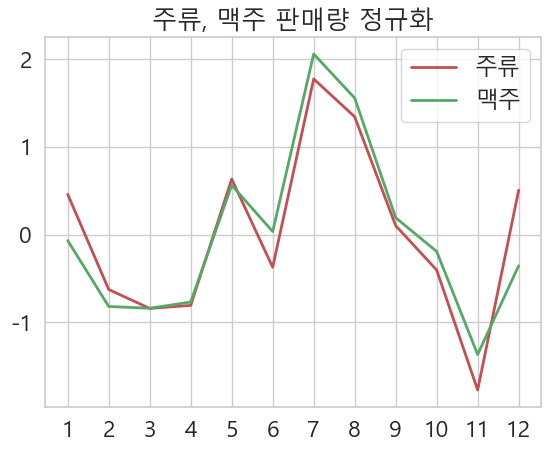

In [59]:
# 정규화 함수
def normalize(x):
    return (x - x.mean())/x.std()

def show_large_product_norm(product):
    df_norm = df.query(f'large_product_cat == "{product}"')
    monthly_count = normalize(df_norm.groupby(['month'])['buy_count'].sum())
    
    return monthly_count

def show_mid_product_norm(product):
    df_norm = df.query(f'mid_product_cat == "{product}"')
    monthly_count = normalize(df_norm.groupby(['month'])['buy_count'].sum())
    
    return monthly_count

def show_norm_grahp(product1, product2):

    plt.plot(list(range(1, 12+1)),(show_large_product_norm(f"{product1}")), c = 'r',linewidth=2, label = f'{product1}')
    plt.plot(list(range(1, 12+1)),(show_mid_product_norm(f"{product2}")), c = 'g',linewidth=2, label = f'{product2}')
    plt.legend()
    plt.title(f'{product1}, {product2} 판매량 정규화')
    plt.xticks(list(range(1, 12+1)))
    plt.grid(True)
    plt.show()

# 주류와 맥주의 판매량 정규화 그래프
show_norm_grahp("주류", "맥주")

In [60]:
# 월별 중분류 주류의 판매량 그래프와 추세선 함수
def show_mid_product_day(product, month):
    df_ex = df.query(f'mid_product_cat == "{product}"')
    monthly_count = df_ex.query(f"month in [{month}]").groupby(['month', 'day'])['buy_count'].sum()
 
    return monthly_count

def show_mid_product_day_grahp(product, month, day):
    plt.figure(figsize= (12, 10))
    coefficients = np.polyfit(list(range(1, day+1)), (show_mid_product_day(f"{product}", f'{month}')), 3)  # 추세선 계수 구하기
    trendline = np.poly1d(coefficients)                                                                # 추세선 함수 생성
    plt.plot(list(range(1, day+1)), trendline(list(range(1, day+1))), color = "r", label='추세선')
    
    plt.plot(list(range(1, day+1)),(show_mid_product_day(f"{product}", f'{month}')), c = 'g',linewidth=2, marker = '.', label = f'{product}')
    plt.legend()
    plt.title(f'{month}월, {product} 판매량')
    plt.xticks(list(range(1, day+1)))
    plt.grid(True)
    plt.show()

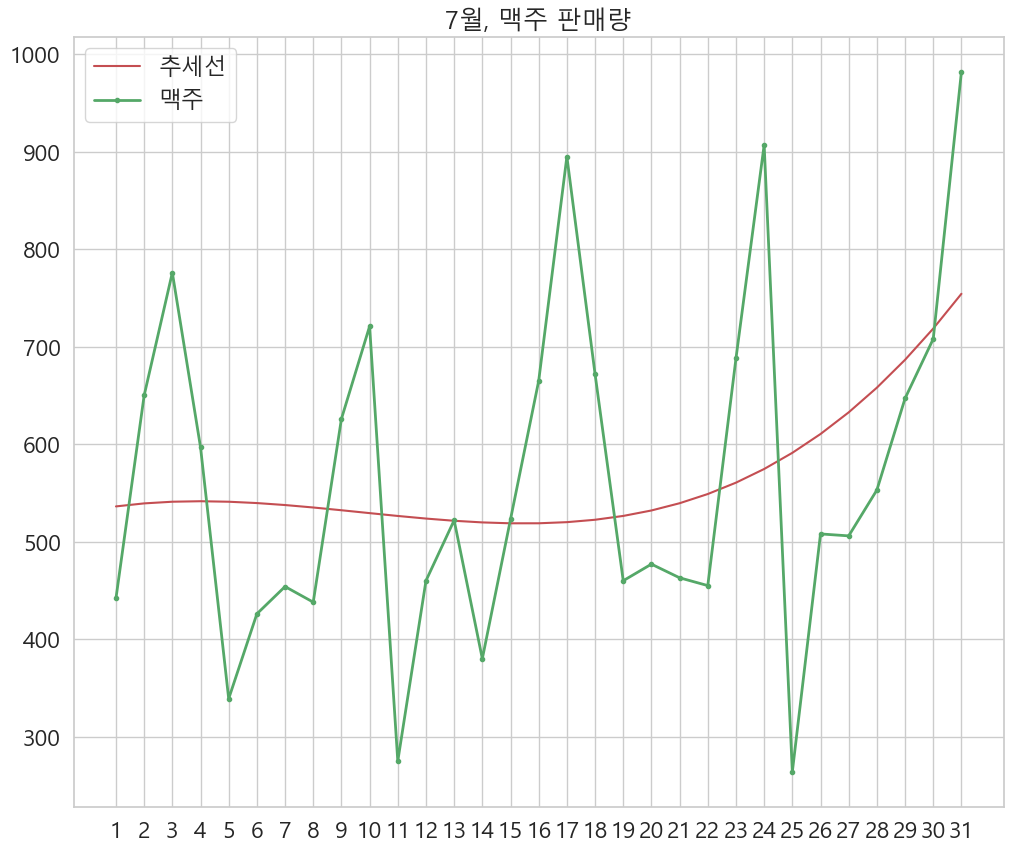

In [61]:
# 7월의 맥주 판매량 그래프와 추세선
show_mid_product_day_grahp("맥주", 7, 31)

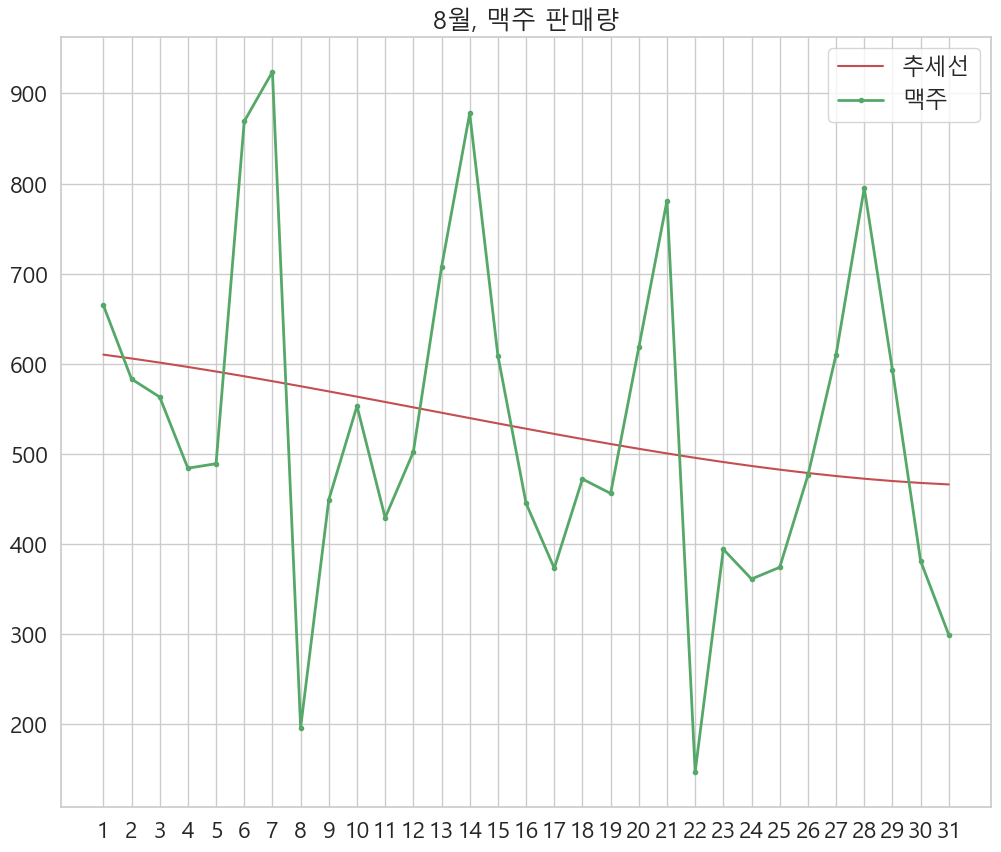

In [62]:
# 8월의 맥주 판매량 그래프와 추세선
show_mid_product_day_grahp("맥주", 8, 31)

- 도쿄올림픽 개막일인 7월 23일 부근부터 점점 증가해 8월 8일 부근으로 갈수록 감소하는 것을 확인
- 대부분의 상품 판매량은 월마다 고점을 찍는 주기와 2번의 최저점이 존재하는데, 고점은 모두 토요일이고 최저점은 둘째/넷째 주 일요일로 보아 토요일이 고객들이 가장 구매를 선호하는 요일이며, 둘째/넷째 주 일요일 대형마트 규제인 의무휴업일로 인한 판매량 감소라는 것을 파악함.

### 5) <u>시간</u> 분석

In [63]:
# 시간별 주류 구매량
df.groupby('buy_hour').size().reset_index()

,buy_hour,0
0,0,966
1,1,449
2,2,225
3,3,107
4,4,112
5,5,80
6,6,79
7,7,95
8,8,145
9,9,243


In [64]:
# 6, 7, 8월 시간별 주류 구매량

# 6, 7, 8월(여름)으로 한정시키기
summer_df = df[(df['buy_date'].dt.month >= 6) & (df['buy_date'].dt.month <= 8)]

# 6, 7, 8월 시간별 주류 구매량
summer_df.groupby('buy_hour').size().reset_index()

,buy_hour,0
0,0,288
1,1,108
2,2,48
3,3,14
4,4,26
5,5,30
6,6,24
7,7,19
8,8,42
9,9,64


### 5-1) <u>시간</u> 분석 시각화

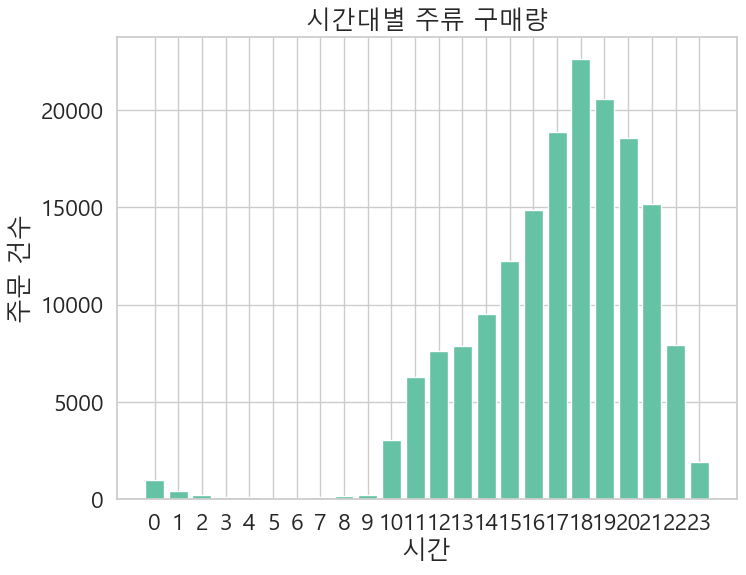

In [65]:
# 시간별 주류 구매량 그래프

# 시간별로 묶기
hour_df = df.groupby('buy_hour').size().reset_index()
# 열이름 바꾸기
hour_df.columns = ['buy_hour', 'order_count']

# 시간별 주류 구매량 그래프
plt.figure(figsize= (8, 6))
plt.bar(hour_df['buy_hour'], hour_df['order_count'])
plt.xticks(range(24), range(24))
plt.xlabel('시간')
plt.ylabel('주문 건수')
plt.title('시간대별 주류 구매량')
plt.show()

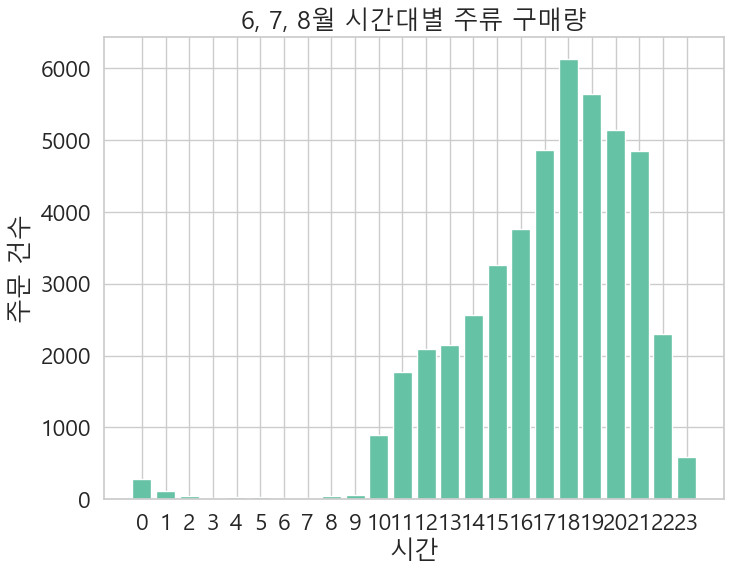

In [66]:
# 6, 7, 8월 시간별 주류 구매량

# 6, 7, 8월(여름)으로 한정시키기
summer_df = df[(df['buy_date'].dt.month >= 6) & (df['buy_date'].dt.month <= 8)]

summer_hour_df = summer_df.groupby('buy_hour').size().reset_index()
summer_hour_df.columns = ['buy_hour', 'order_count']

# 6, 7, 8월 시간별 주류 구매량 그래프
plt.figure(figsize= (8, 6))
plt.bar(summer_hour_df['buy_hour'], summer_hour_df['order_count'])
plt.xlabel('시간')
plt.xticks(range(24), range(24))
plt.ylabel('주문 건수')
plt.title('6, 7, 8월 시간대별 주류 구매량')
plt.show()

### 6) <u>지역</u> 분석

In [67]:
# 지역별 중분류 주류 판매액
loc_mid_amount_df = df.groupby(['location', 'mid_product_cat'])['buy_amount'].sum().reset_index();loc_mid_amount_df

,location,mid_product_cat,buy_amount
0,Z01,맥주,6356140.0
1,Z01,소주,3236330.0
2,Z01,양주,1213190.0
3,Z01,와인,2342530.0
4,Z01,전통주,975680.0
...,...,...,...
97,Z17,소주,40325510.0
98,Z17,양주,31693980.0
99,Z17,와인,194724380.0
100,Z17,전통주,28325700.0


In [68]:
# 지역별 중분류 주류 판매량
loc_mid_count_df = df.groupby(['location', 'mid_product_cat'])['buy_count'].sum().reset_index();loc_mid_count_df

,location,mid_product_cat,buy_count
0,Z01,맥주,2413
1,Z01,소주,1400
2,Z01,양주,69
3,Z01,와인,161
4,Z01,전통주,537
...,...,...,...
97,Z17,소주,17181
98,Z17,양주,1334
99,Z17,와인,8748
100,Z17,전통주,9869


In [69]:
# 지역별 맥주 판매액
loc_beer_amount_df = beer.groupby('location')['buy_amount'].sum().reset_index();loc_beer_amount_df

,location,buy_amount
0,Z01,6356140.0
1,Z02,1129270.0
2,Z03,6951940.0
3,Z04,38611490.0
4,Z05,15593536.0
5,Z06,22698542.0
6,Z07,2130790.0
7,Z08,14922100.0
8,Z09,16160770.0
9,Z10,149117070.0


In [70]:
# 지역별 맥주 판매량
loc_beer_count_df = beer.groupby('location')['buy_count'].sum().reset_index();loc_beer_count_df

,location,buy_count
0,Z01,2413
1,Z02,305
2,Z03,1554
3,Z04,9655
4,Z05,3657
5,Z06,5982
6,Z07,489
7,Z08,4038
8,Z09,4374
9,Z10,45288


In [71]:
# 지역별 점포 수 
loc_store = df.groupby('location')['market_code'].nunique();loc_store

location
Z01     114
Z02      47
Z03     123
Z04     368
Z05     142
Z06     201
Z07      60
Z08     140
Z09     140
Z10    1210
Z11     256
Z12     142
Z13     156
Z14     215
Z15     140
Z16     395
Z17    1250
Name: market_code, dtype: int64

In [72]:
# 지역별 고객 수
loc_customer = df.groupby('location')['customer_id'].nunique();loc_customer

location
Z01     225
Z02      28
Z03     254
Z04     930
Z05     337
Z06     588
Z07      78
Z08     335
Z09     328
Z10    3838
Z11     922
Z12     313
Z13     450
Z14     310
Z15     257
Z16    1138
Z17    3915
Name: customer_id, dtype: int64

In [73]:
# 지역별로 주류 판매액을 점포 수로 나는 비율
loc_store = df.groupby('location')['market_code'].nunique()
loc_amount_df = df.groupby('location')['buy_amount'].sum()

loc_store_ratio = loc_amount_df / loc_store;loc_store_ratio

location
Z01    124092.719298
Z02     53421.914894
Z03    139090.650407
Z04    257549.630435
Z05    230748.492958
Z06    227734.437811
Z07     97898.000000
Z08    225817.535714
Z09    212660.571429
Z10    289781.809917
Z11    306777.500000
Z12    156549.929577
Z13    216913.461538
Z14    107443.906977
Z15    165985.428571
Z16    339097.734177
Z17    402172.255200
dtype: float64

### 6-1) <u>지역</u> 분석 시각화

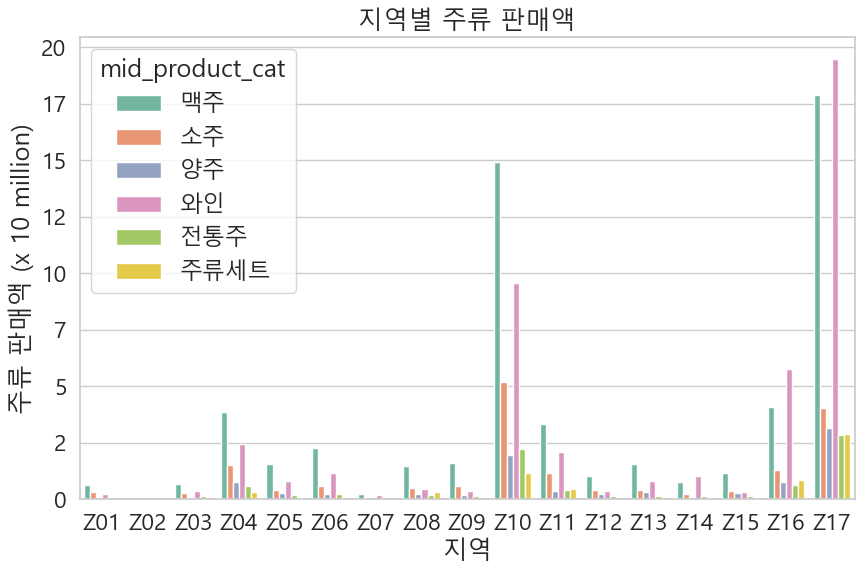

In [74]:
# 지역별 주류 판매액 그래프
plt.figure(figsize=(10,6))
sns.barplot(data=loc_mid_amount_df, x='location', y='buy_amount', hue='mid_product_cat')

# y축 값 정수로 표현
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x/10000000):,}'))

plt.title('지역별 주류 판매액')
plt.xlabel('지역')
plt.ylabel('주류 판매액 (x 10 million)')

plt.show()

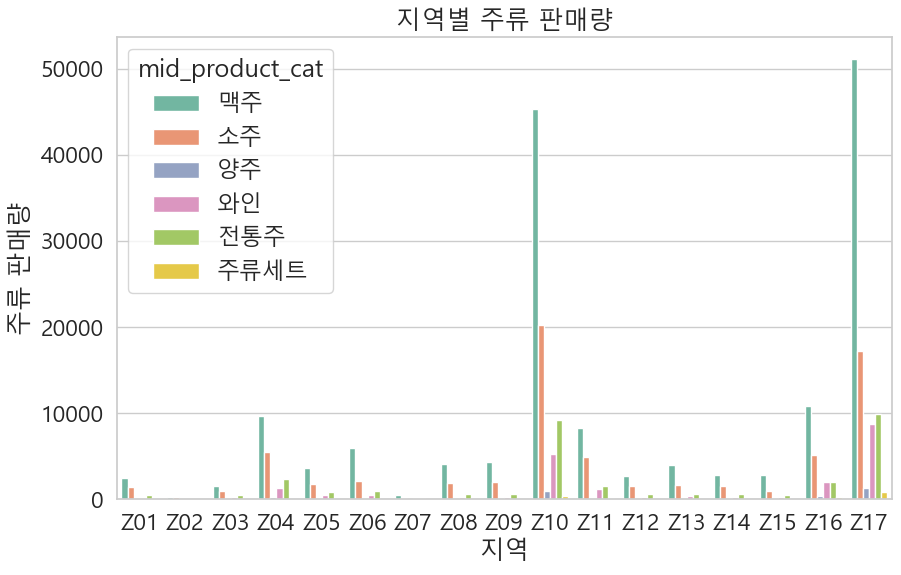

In [75]:
# 지역별 주류 판매량 그래프
plt.figure(figsize=(10,6))
sns.barplot(data=loc_mid_count_df, x='location', y='buy_count', hue='mid_product_cat')
plt.title('지역별 주류 판매량')
plt.xlabel('지역')
plt.ylabel('주류 판매량')

plt.show()

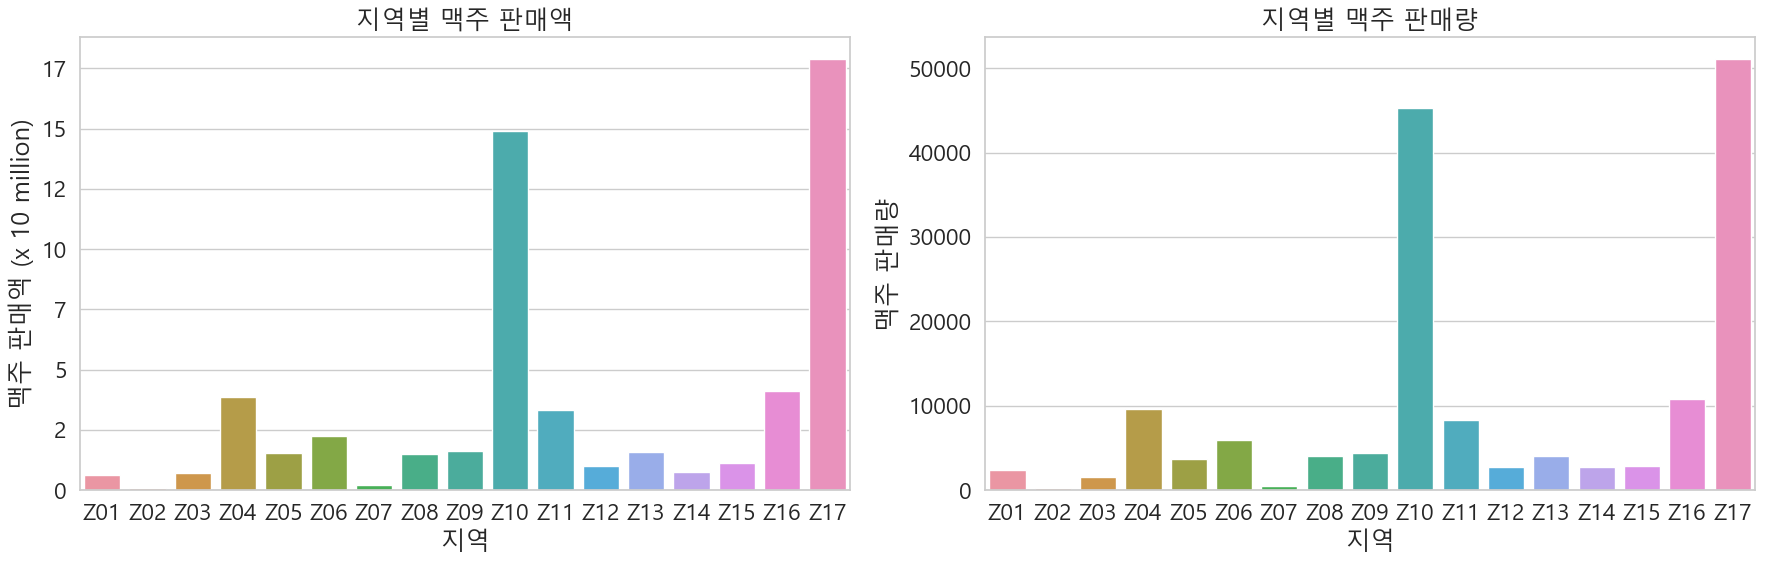

In [76]:
# 지역별 맥주 판매액 그래프와 지역별 맥주 판매량 그래프
plt.figure(figsize=(18, 6))

# 왼쪽 그래프: 맥주 판매액
plt.subplot(1, 2, 1)
sns.barplot(data=loc_beer_amount_df, x='location', y='buy_amount')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x/10000000):,}'))
plt.xlabel('지역')
plt.ylabel('맥주 판매액 (x 10 million)')
plt.title('지역별 맥주 판매액')

# 오른쪽 그래프: 맥주 판매량
plt.subplot(1, 2, 2)
sns.barplot(data=loc_beer_count_df, x='location', y='buy_count')
plt.xlabel('지역')
plt.ylabel('맥주 판매량')
plt.title('지역별 맥주 판매량')
plt.tight_layout()
plt.show()

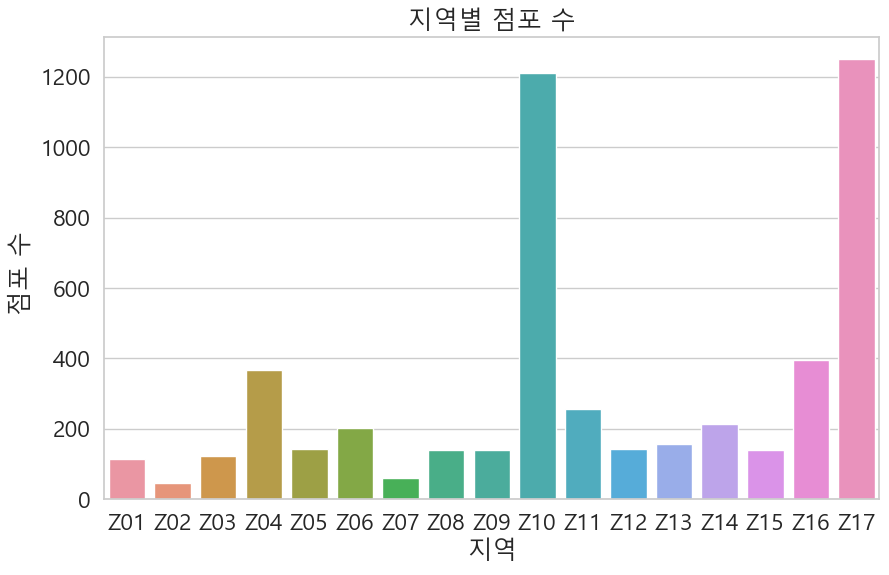

In [77]:
# 지역별 점포 수 그래프
plt.figure(figsize=(10,6))
sns.barplot(x = loc_store.index, y = loc_store.values)
plt.xlabel('지역')
plt.ylabel('점포 수 ')
plt.title('지역별 점포 수')
plt.show()

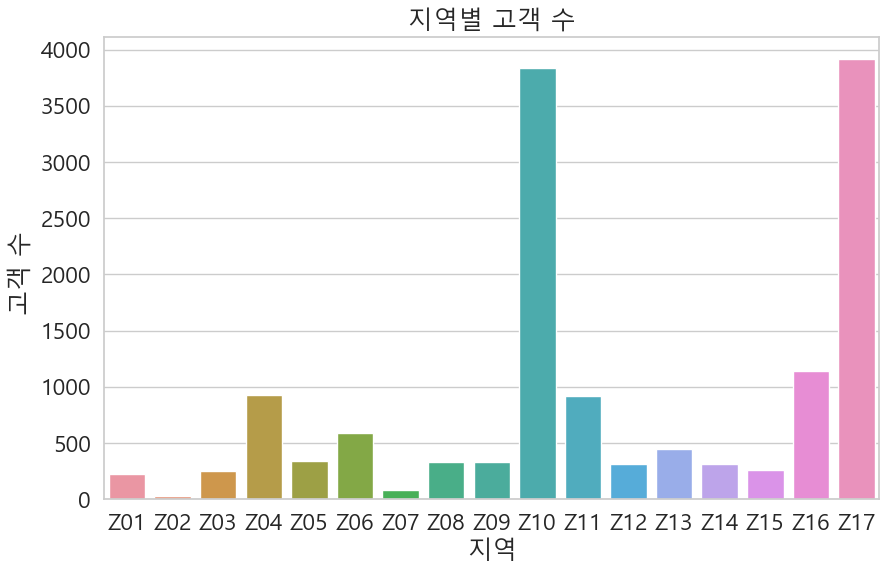

In [78]:
# 지역별 고객 수 그래프
plt.figure(figsize=(10,6))
sns.barplot(x = loc_customer.index, y = loc_customer.values)
plt.xlabel('지역')
plt.ylabel('고객 수 ')
plt.title('지역별 고객 수')
plt.show()

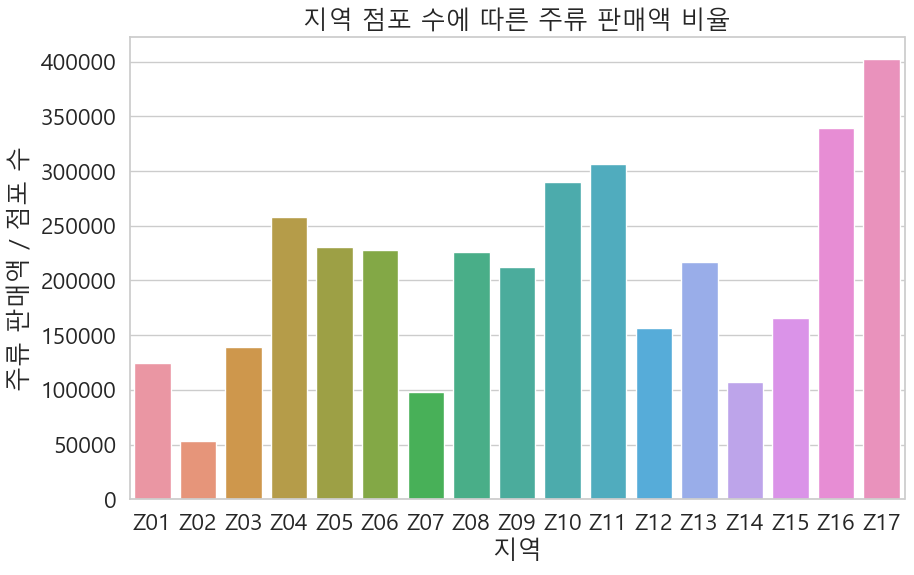

In [79]:
# 지역 점포 수에 따른 주류 판매액 비율 그래프
plt.figure(figsize = (10,6))
sns.barplot(x = loc_store_ratio.index, y = loc_store_ratio.values)
plt.xlabel('지역')
plt.ylabel('주류 판매액 / 점포 수')
plt.title('지역 점포 수에 따른 주류 판매액 비율')
plt.show()

## **4. 여름 신제품 출시 활용부분(가격)**
- 신제품 : 맥주
- 신제품의 가격 설정
- 맥주는 특히나 가격과 판매량의 관계가 강함
- 95% 신뢰구간의 하한 신뢰경계로 설정

In [80]:
# 평균 가격과 신뢰구간 측정
def confidence_interval(data, confidence):
    data=np.array(data)
    mean=np.mean(data)
    n=len(data)
    stderr=stats.sem(data)
    interval=stderr*stats.t.ppf((1+confidence)/2, n-1)
    return (mean, mean-interval, mean+interval)

# 맥주의 가격에 대한 신뢰구간
confidence_interval(beer['price'], confidence=0.95)

(4324.55954820901, 4295.214781137749, 4353.9043152802715)